# Bitcoin Modelling Part 1

__Niklas Gutheil__<br>
__2022-04-01__


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

## Table of Contents

* [Introduction](#introduction)<br>
* [Load in Data](#load)<br>
* [Scale Data](#scale)<br>
* [Train-Test Split](#split)<br>
* [SARIMAX Modelling](#sarimax)<br>
  * [Base Model](#sarimax_base)<br>
    * [ACF and PACF Plots](#pacf)<br>
    * [Base SARIMAX Model](#base_model)<br>
  * [Adding Individual Features](#individual)<br>
  * [Feature Combination Optimization](#optimize)<br>


## Introduction <a name="introduction"></a>

In this notebook I will implement a SARIMAX model on the Bitcoin Timeseries and add features one by one to see if they improve the model. The purpose of this project is to showcase things to look out for when building timeseries models in the context of Bitcoin and the larger Cryptocurrency market, including any useful features. Several features were created during the Feature Engineering stage such as the Fear and Greed Index, the Puell Multiple and the Stock-to-Flow model, all of which will be tested in this notebook. <br>

Initially I will build and train a model that only includes the target variable `Open`, optimize for its hyperparameters with a grid search and perform cross-validation. After that I will re-train the model by adding one new feature and seeing if the evaluation metric `Mean Absolute Percentage Error (MAPE)` has improved. MAPE is a calculation of what percentage, on average, our prediction is off from the actual value. This should showcase which variables have a positive affect on scoring.
<br>


The features to be used as exogenous variables are: 
* __EMA_7__
* __EMA_14__
* __EMA_21__
* __EMA_28__
* __EMA_50__
* __EMA_100__
* __EMA_250__
* __On-balance Volume__
* __Volume__
* __Fear and Greed Index__ 
*__RSI__
*__Puell Multiple__
*__Stock-to-Flow Model 463 Day__
<br>

## Load in Data <a name="load"></a>

The first step is to load in our dataset, which will be the 1 Day Historical Price Data Modelling for Bitcoin I created in the `Bitcoin Historical Price Data Feature Engineering for 1-Day Intervals` notebook. Since this notebook is being created in Google Colab for additional computing resources, the loading process is a little different. First I have run a command that will let the user chose a file from their local drive. Following that is another Google Colab specific command to load in the dataset into a dataframe. Once I have that loaded in, I will also set the index to the `Date` column and also make sure the date is of the DateTime dtype.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving BTCUSD 1D Historical_Data_Modelling.csv to BTCUSD 1D Historical_Data_Modelling.csv


In [3]:
import io
bitcoin_df = pd.read_csv(io.BytesIO(uploaded['BTCUSD 1D Historical_Data_Modelling.csv']))
bitcoin_df.head()

,Date,Open,Close,High,Low,Volume,stock,S2F_463MA,Puell,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
0,2014-07-21,619.705764,619.601719,619.935799,619.400799,9.087344,12713200.0,296.577891,1.283667,0.0,-9.087344,622.811814,623.160314,621.802946,619.088556,605.994310,586.716801,549.612234,0.442006
1,2014-07-22,621.136302,621.084288,621.305139,620.849149,7.947902,12716800.0,296.846171,1.282735,0.0,7.947902,622.379933,622.883511,621.737613,619.226193,606.586074,587.397408,550.195993,0.465235
2,2014-07-23,619.220937,619.266771,619.425382,619.076406,5.353119,12720400.0,297.115114,1.274937,0.0,-5.353119,621.601642,622.401279,621.512991,619.228991,607.083356,588.028543,550.760026,0.437999
3,2014-07-24,609.045365,609.008872,609.521875,608.433455,33.808630,12724000.0,297.384220,1.250308,0.0,-33.808630,618.453450,620.615624,620.376253,618.524155,607.158866,588.444032,551.235593,0.311621
4,2014-07-25,600.420677,600.425868,600.741788,600.079375,14.212595,12727600.0,297.653489,1.229068,0.0,-14.212595,613.946554,617.923657,618.562582,617.275997,606.894827,588.681317,551.637123,0.247059


In [4]:
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
bitcoin_df.set_index('Date', inplace = True)
display(bitcoin_df.index)

DatetimeIndex(['2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30',
               ...
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01'],
              dtype='datetime64[ns]', name='Date', length=2722, freq=None)

The index has been set correctly and I can move on to creating a Train-Test Split. Before doing this though, I am going to choose to drop the features `Close`, `High` and `Low` as they are too similar to the target variable and will needlesly complicate the model process. I will also drop `stock` as that feature is simply too linear when graphed.

In [5]:
# add lines for each column
fig = px.line(bitcoin_df, x=bitcoin_df.index, y=['stock'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Supply in BTC", 
    legend_title="", 
    title="Circulating Supply of Bitcoin 2014-2022"
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       # diagonally and shifting the y-axis manually, plotly does not 
                                                       # currently support y-axis autoscaling
fig.update_xaxes(rangeslider_visible=True)


fig.show()

In [6]:
bitcoin_df.drop(columns = ['Close', 'High', 'Low', 'stock'], inplace = True)
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2722 entries, 2014-07-21 to 2022-01-01
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2722 non-null   float64
 1   Volume     2722 non-null   float64
 2   S2F_463MA  2722 non-null   float64
 3   Puell      2722 non-null   float64
 4   fg_index   2722 non-null   float64
 5   OBV        2722 non-null   float64
 6   EMA_7      2722 non-null   float64
 7   EMA_14     2722 non-null   float64
 8   EMA_21     2722 non-null   float64
 9   EMA_28     2722 non-null   float64
 10  EMA_50     2722 non-null   float64
 11  EMA_100    2722 non-null   float64
 12  EMA_250    2722 non-null   float64
 13  RSI        2722 non-null   float64
dtypes: float64(14)
memory usage: 319.0 KB


Now that I have the features needed for modelling, I will begin to create a Train/Test split.

## Train-Test Split <a name="split"></a>

The split will occur on July 1st, 2021. This gives just over 7 years of training data. The test data will be 2 weeks into the future. The reason I chose this point is for several reasons. This is a time where prices were relatively stable for a month, and then went into a further downtrend. (see graph below). I also chose 2 weeks as ARIMA models aren't great at predicting too far ahead. I could have set the training period to the start of the 2020 Bull-run, but such sudden price action can be very hard to predict, even by professional analysts. Additionally, I want to include enough data from the Fear and Greed Index to make sure the feature has a chance of showing its usefulnes. 

In [7]:
# add lines for each column
fig = px.line(bitcoin_df, x=bitcoin_df.index, y=['Open'],)

# axis labels and title
fig.update_layout(
    yaxis_title="Price in USD", 
    legend_title="", 
    title="Price of Bitcoin 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)

# activate slider
fig.update_yaxes(fixedrange = False, autorange = True) # you can zoom in on the y-axis by dragging the bottom corners 
                                                       
fig.update_xaxes(rangeslider_visible=True, range=['2021-05-01', '2021-09-01'])

fig.add_vline(x = '2021-07-01')


fig.show()

In [8]:
train = bitcoin_df[bitcoin_df.index < '2021-07-01']
test = bitcoin_df[(bitcoin_df.index >= '2021-07-01') & (bitcoin_df.index <= '2021-07-15')]

In [9]:
train.tail(3)

,Open,Volume,S2F_463MA,Puell,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
Date,,,,,,,,,,,,,,
2021-06-28,34492.251606,21.448459,33656.058114,0.948925,25.0,21.448459,33683.831286,34478.515671,35292.171628,36215.257688,39246.525833,42566.193715,37987.445831,0.496679
2021-06-29,35558.544231,19.144583,33797.869906,0.976986,25.0,19.144583,34153.787304,34623.200963,35316.851967,36170.319597,39102.099540,42427.529589,37968.132759,0.556716
2021-06-30,35091.281052,12.667995,33939.699374,0.962932,28.0,-12.667995,34386.786635,34684.878785,35295.845846,36095.524082,38944.596994,42282.148501,37945.165842,0.526361


In [10]:
test.head(3)

,Open,Volume,S2F_463MA,Puell,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
Date,,,,,,,,,,,,,,
2021-07-01,33716.208585,22.997432,34081.546519,0.924135,28.0,-22.997432,34217.920349,34555.071146,35151.798177,35931.096317,38739.370504,42112.429154,37911.430030,0.440360
2021-07-02,33290.346046,17.866111,34223.411342,0.911440,21.0,-17.866111,33986.280614,34386.576514,34982.667562,35749.045633,38525.723088,41937.754545,37874.616734,0.416771
2021-07-03,34313.193655,10.300798,34365.293844,0.938310,24.0,10.300798,34069.072689,34377.359501,34922.193139,35650.314825,38360.692728,41786.857404,37846.272768,0.492510


The data has been split at the right date, now I have to split them into X_train, X_test, y_train, y_test, where y_train/test are the target variable `Open`, and X_train/test are the other exongenous variables for our firsts model SARIMAX.

In [11]:
X_train = train.drop(columns = 'Open')
y_train = train['Open']

X_test = test.drop(columns = 'Open')
y_test = test['Open']

print(X_train.head(3))
print('---------------------------')
print(y_train.head(3))

              Volume   S2F_463MA     Puell  fg_index       OBV       EMA_7  \
Date                                                                         
2014-07-21  9.087344  296.577891  1.283667       0.0 -9.087344  622.811814   
2014-07-22  7.947902  296.846171  1.282735       0.0  7.947902  622.379933   
2014-07-23  5.353119  297.115114  1.274937       0.0 -5.353119  621.601642   

                EMA_14      EMA_21      EMA_28      EMA_50     EMA_100  \
Date                                                                     
2014-07-21  623.160314  621.802946  619.088556  605.994310  586.716801   
2014-07-22  622.883511  621.737613  619.226193  606.586074  587.397408   
2014-07-23  622.401279  621.512991  619.228991  607.083356  588.028543   

               EMA_250       RSI  
Date                              
2014-07-21  549.612234  0.442006  
2014-07-22  550.195993  0.465235  
2014-07-23  550.760026  0.437999  
---------------------------
Date
2014-07-21    619.705764
2014-

The next step is to scale the data.

## Scale Data <a name="scale"></a>

Some of the features I will be using have vastly different scales from each other, so its important to scale them down to the same ranges. To do this I will implement a MinMax Scaler that will scale each feature individually to a range between 0 and 1. 

I will fit the scaler on the X_train, and then transform X_train and X_test to ensure there is no data leakage. 

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)


## SARIMAX Modelling <a name="sarimax"></a>

Finally I can move on to modelling a Timeseries for the Bitcoin Dataset. To start, I will implement a SARIMAX model. SARIMAX is an acronym which I will explain below, including what hyperparameters tune these variables.<br><br>

__S__: Seasonality. Here we can specify the seasonality our data exhibits and is stored in `s` where the value is the number of time intervals in your dataset that make up that seasonality. For example, 1 month data would have s = 12 for yearly seasonality.<br>

__AR__: Autoregressive. This is how similar the data are to previous data at any given time interval or period prior. In simpler terms, it represents repeating patterns in the data. Auto-regressive means the data are regressed with a certain lag-period of previous data, and finds where the regression is strongest, representing a pattern in the data. Represented as `p` in the model.<br>

__I__: Integrated. It indicates that the data values have been replaced with the difference between their values and the previous values. Represented as `d` in the model.<br>

__MA__: Moving Average. This term calculates the moving average over a given number of periods. It is used to reduce noise in a model or smooth it out. The longer the moving average period, the more smoothed out the noise would be. Represented as `q` in the model.<br>

__X__: Exogenous. This takes into account a known external factor and is an array of exogenous regressors that we can add to the model. In my case, its the features stored in X_train/X_test.

### Base Model <a name="sarimax_base"></a>

Here I will build a base SARIMAX model where I only include the target variable `Open` stored in y_train/y_test. Before doing that, I need to establish a baseline for model evaluation. This will simply be the mean over the training set, and then evaluated using Mean Absolute Percentage Error as explained previously.

In [13]:
predictions = pd.Series(data=np.full((y_train.shape[0] + y_test.shape[0], ), np.mean(y_train)), index=pd.concat([y_train, y_test]).index)

In [14]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Mean Prediction"))

fig.update_layout(
    yaxis_title="Price in USD", 
    xaxis_title="Date",
    title="Price of Bitcoin from 2014-2022", 
    yaxis_tickprefix = '$', 
    yaxis_tickformat = ',.2f'
)
fig.show()

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

train_mape = 100*mean_absolute_percentage_error(y_train, predictions[y_train.index])
test_mape = 100*mean_absolute_percentage_error(y_test, predictions[y_test.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 780.47%
Test MAPE on the difference: 76.96%


The base MAPE scores for the train data is 780.47% while for the test data it is 76.96%.<br>

Now I will begin to build the SARIMAX model. To build a more efficient model, I can try to find the `q` and `p` variables with a ACF and PACF plot respectively. 

#### ACF and PACF Plots <a name="pacf"></a>

I will start by building an ACF plot with lag 365 to account for yearly seasonality. As we have previously discovered though during the EDA phase, Bitcoins price does not have much of a seasonality, and is better captured with multiple seasonalities. For the plots though, we have to specify which seasonality as the SARIMAX model only accounts for a sinlge seasonality, one of its major downsides. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



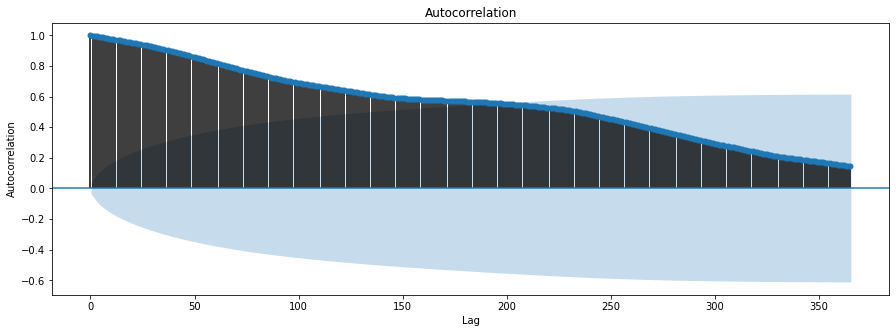

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# this cell might take a few seconds to run
plt.figure(figsize=(15, 5))

# plot ACF graph with lag = 365
plot_acf(bitcoin_df["Open"], lags=365, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

It appears that around lag = 175 the autocorrelation begins to fall into the 95% confidence interval for non-significant correlation. This would suggest a `q` value around 175, and our `s` value be set to 365 for yearly seasonality. Running the above plot again with quarterly, monthly or weekly seasonality shows the autocorrelation never dipping into the confidence interval. However, setting the `q` value to such a high number, leads to unrealistic run times, even when using Google Colab Pro+ on the best available hardware. Generally this number is around 0-2, so I will be using that number as well. Another shortcoming of SARIMAX models is that they do not handle long seasonalities well as [discussed here](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a). Due to this constraint, I will omit the s value as I have previously explored there is no defined seasonality in the Bitcoin dataset. Accounting for a random seasonality might simply introduce erorr. This way we can also keep run times managable. <br>

Next up is the PACF plot to determine a good starting point for `p`.

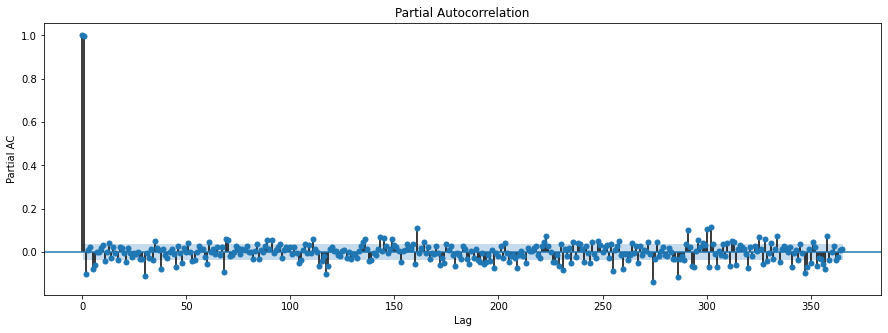

In [17]:
plt.figure(figsize=(15, 5))
plot_pacf(bitcoin_df["Open"].dropna(), lags=365, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

It is clear that there are a number of lags throughout that are considered significant, but this is to be expected as we have at least multi-seasonality in the dataset. The highest significance lags are at lag = 1 and 2, so we will set the `p` value around 2, although I will be trying several values in the grid searches. <br>

It's time to move on to build the first SARIMAX model.

#### Base SARIMAX Model <a name="base_model"></a>

To find the best hyperparameters in the model, I will define a grid search function for the SARIMAX model that will take the data and run it through many combinations of hyperparameters, returning the best 5 models. The best models are determined by their BIC score. The Bayesian Information Criterion, or BIC for short, is a method for scoring and selecting a model. It is appropriate for models fit under the maximum likelihood estimation framework, which SARIMAX is.<br>

Some hyperparameters not discussed so far: <br>
* d: Degree, controls how many times the series is differentiated. Usually this value is set to around 1, but I will test a range from 0-3 exclusive.<br><br>

Since we have omitted the seasonality and havent added any exogenous variables, this is technically an ARIMA model.

__NOTE: This code was taken from [here](https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b) and modified for my own purposes__

In [18]:
import itertools
import statsmodels.api as sm



# Define function
def sarimax_gridsearch(ts, pdq, maxiter=1000, freq='D'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='D' for day. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        
            
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, output.bic])
                print('ARIMA {} : BIC Calculated ={}'.format(comb, output.bic))
            
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df


In [19]:
# Define parameter ranges, higher numbers will take longer to run

p = np.arange(0, 4, 1) 

q = np.arange(0,4,1)

d = np.arange(0,4,1)


# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))


### Run Grid Search ###

# Note: this code will take a while to run

# Change frequency to match your time series data
answer_df = sarimax_gridsearch(y_train, pdq, freq='D')

ARIMA (0, 0, 0) : BIC Calculated =55674.76618589292
ARIMA (0, 0, 1) : BIC Calculated =53790.77923307419
ARIMA (0, 0, 2) : BIC Calculated =53550.88138823914
ARIMA (0, 0, 3) : BIC Calculated =53186.2872061248
ARIMA (0, 1, 0) : BIC Calculated =39050.76785453953
ARIMA (0, 1, 1) : BIC Calculated =38994.11153425459
ARIMA (0, 1, 2) : BIC Calculated =38975.77658250878
ARIMA (0, 1, 3) : BIC Calculated =38953.015969438304
ARIMA (0, 2, 0) : BIC Calculated =40390.23106055598
ARIMA (0, 2, 1) : BIC Calculated =39067.17421754905
ARIMA (0, 2, 2) : BIC Calculated =39000.16386146695
ARIMA (0, 2, 3) : BIC Calculated =38977.836676752384
ARIMA (0, 3, 0) : BIC Calculated =43059.22206805203
ARIMA (0, 3, 1) : BIC Calculated =40438.97176726867


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 3, 2) : BIC Calculated =39378.145726645416
ARIMA (0, 3, 3) : BIC Calculated =39244.64114679476
ARIMA (1, 0, 0) : BIC Calculated =39072.564027224355
ARIMA (1, 0, 1) : BIC Calculated =39016.209856610156
ARIMA (1, 0, 2) : BIC Calculated =38997.981145529055
ARIMA (1, 0, 3) : BIC Calculated =38975.136223779176
ARIMA (1, 1, 0) : BIC Calculated =39003.40663670549
ARIMA (1, 1, 1) : BIC Calculated =38995.530311777795
ARIMA (1, 1, 2) : BIC Calculated =38956.756969474074
ARIMA (1, 1, 3) : BIC Calculated =38945.469053931476
ARIMA (1, 2, 0) : BIC Calculated =39841.793574823496
ARIMA (1, 2, 1) : BIC Calculated =38987.912092338025
ARIMA (1, 2, 2) : BIC Calculated =38999.1459259969
ARIMA (1, 2, 3) : BIC Calculated =38940.660540948586
ARIMA (1, 3, 0) : BIC Calculated =41643.25041761233
ARIMA (1, 3, 1) : BIC Calculated =39981.733058172045


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 3, 2) : BIC Calculated =39173.00766332004
ARIMA (1, 3, 3) : BIC Calculated =39198.570948768
ARIMA (2, 0, 0) : BIC Calculated =39011.16331240099
ARIMA (2, 0, 1) : BIC Calculated =39018.202323037076
ARIMA (2, 0, 2) : BIC Calculated =39014.973789157535
ARIMA (2, 0, 3) : BIC Calculated =38967.967830779286
ARIMA (2, 1, 0) : BIC Calculated =38994.53872022689
ARIMA (2, 1, 1) : BIC Calculated =39003.230540419114
ARIMA (2, 1, 2) : BIC Calculated =38958.98163462581
ARIMA (2, 1, 3) : BIC Calculated =38952.32629205931
ARIMA (2, 2, 0) : BIC Calculated =39686.464518948735
ARIMA (2, 2, 1) : BIC Calculated =38993.50370048525
ARIMA (2, 2, 2) : BIC Calculated =38981.222459419776
ARIMA (2, 2, 3) : BIC Calculated =38954.101565011064
ARIMA (2, 3, 0) : BIC Calculated =41226.706077302995


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (2, 3, 1) : BIC Calculated =39686.53157424032
ARIMA (2, 3, 2) : BIC Calculated =39165.32615224702


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (2, 3, 3) : BIC Calculated =39164.95989148342
ARIMA (3, 0, 0) : BIC Calculated =39002.33158448
ARIMA (3, 0, 1) : BIC Calculated =38990.09339864928
ARIMA (3, 0, 2) : BIC Calculated =38981.4905864235
ARIMA (3, 0, 3) : BIC Calculated =38980.06416056686
ARIMA (3, 1, 0) : BIC Calculated =38976.3401939955
ARIMA (3, 1, 1) : BIC Calculated =38965.02363785099
ARIMA (3, 1, 2) : BIC Calculated =38966.631890235374
ARIMA (3, 1, 3) : BIC Calculated =38956.10000068874
ARIMA (3, 2, 0) : BIC Calculated =39378.27538766945
ARIMA (3, 2, 1) : BIC Calculated =38975.134572793795
ARIMA (3, 2, 2) : BIC Calculated =38965.348562804465
ARIMA (3, 2, 3) : BIC Calculated =38940.036559212596
ARIMA (3, 3, 0) : BIC Calculated =40689.96726031892
ARIMA (3, 3, 1) : BIC Calculated =39378.475128502534
ARIMA (3, 3, 2) : BIC Calculated =39150.26825121645
ARIMA (3, 3, 3) : BIC Calculated =39107.77185983218


In [20]:
answer_df

,pdq,bic
59,"(3, 2, 3)",38940.036559
27,"(1, 2, 3)",38940.660541
23,"(1, 1, 3)",38945.469054
39,"(2, 1, 3)",38952.326292
7,"(0, 1, 3)",38953.015969


I will go ahead and build the individual model where the BIC value is the lowest. p = 3, d = 2 and q = 3

                           Statespace Model Results                           
Dep. Variable:                   Open   No. Observations:                 2537
Model:               SARIMAX(3, 2, 3)   Log Likelihood              -19442.591
Date:                Mon, 04 Apr 2022   AIC                          38899.182
Time:                        00:14:58   BIC                          38940.037
Sample:                    07-21-2014   HQIC                         38914.005
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5514      0.009   -171.193      0.000      -1.569      -1.534
ar.L2         -0.6647      0.016    -42.023      0.000      -0.696      -0.634
ar.L3          0.1405      0.009     15.044      0.0

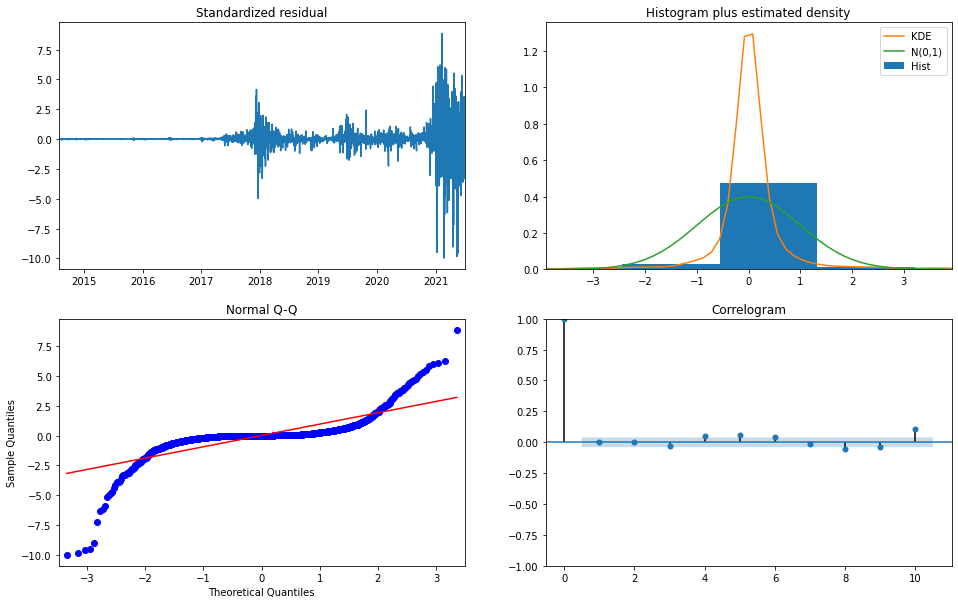

In [21]:
# build SARIMAX model with optimal hyperparameters
sarimax = sm.tsa.statespace.SARIMAX(y_train, 
                                    order=(3,2,3),  
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
# Fit the model
output = sarimax.fit()
    
# Print output summary
print(output.summary())

# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));

Looking at the above summary, we see that all of our parameters were significant. However, the plots tell a different story about the performance of the model. Ideally the residuals should be constant variance around mean 0, but it is clear that the variance increases during the 2017 and 2020 Bull-run. The Normal Q-Q plot also tells us that our residuals were not normally distributed. <br>

Let's go ahead and evaluate this model using MAPE.

In [22]:
predictions = output.predict(start=0, end=len(y_train)+len(y_test)-1)

train_mape = 100*mean_absolute_percentage_error(y_train, predictions[y_train.index])
test_mape = 100*mean_absolute_percentage_error(y_test, predictions[y_test.index])

print(f"Train MAPE on the difference: {round(train_mape, 3)}%")
print(f"Test MAPE on the difference: {round(test_mape, 3)}%")

Train MAPE on the difference: 2.259%
Test MAPE on the difference: 5.105%


In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True, range = ['2021-06-01', '2021-07-30'])
fig.update_yaxes(range=[30000, 39000])
fig.update_layout(
    yaxis_title="Price in USD", 
    xaxis_title="Date",
    title="Price of Bitcoin from 2014-2022"
)
fig.show()

Our prediction isnt very good, but thats to be expected. None of our results are expected to be very good as the underlying data is inherently hard to predict. The main goal of this project is to determine if there are any Cryptocurrency specific metrics (or ideas) that help improve the accuracy. The MAPE on the training data is 2.26% and on the test it is 5.11%<br>

This is an obvious improvement over our base MAPE's of 780.47% on train data and 76.96% for the test data. The improvement on the test data can be seen by inspecting the above graph. The prediction line actually begins at the last data point. The downward trend was also slitghtly captured, something that will hopefully be improved upon by adding exogenous variables.<br>

Let's move on to adding our individual features one-by-one as exogenous variables.

### Adding Individual Features <a name="individual"></a>

SARIMAX models can take an x component, which is an array of regressors that will be used in the model. Our first regressor as stated in the introduction, will be __EMA_7__ followed by __EMA_14, EMA_21, EMA_28, EMA_50, EMA_100, EMA_250, On-balance Volume, Volume, Fear and Greed Index, RSI, Puell Multiple and Stock-to-Flow Model 463 Day.__ To save space in the notebook and increase legability, a loop will be run that trains, optimizes using grid search, and evaluates the model. The outputs will be printed such that the feature, the hyperparameters and MAPE scores are displayed for the best model with that feature. This also makes the model an ARIMAX model. <br>

To begin I will have to redefine the grid search function to accept exogenous variables.

In [24]:
# Define function
def sarimax_gridsearch_exog(ts, exog, pdq, maxiter=1000, freq='D'):
    '''
    Input: 
        ts : your time series data
        exog: array of exogenous variables to be included in modelling
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='D' for day. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        
            
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                exog = exog,
                                                order=comb,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, output.bic])
                # print('ARIMAX {} : BIC Calculated ={}'.format(comb, output.bic))
            
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

The following code does a few things. First it performs a grid search on the first exogenous variable, found in X_train. It then finds the best hyperparameters and builds a single model from it to determine its MAPE for test and train. It appends the scores and model to a list and moves on to the next exogenous variable. Once all variables have been used, the code terminates leaving us 4 seperate lists we can turn into a dataframe, and reference for graphing.

In [25]:
# this cell will take a while to run. There are 13 models being optimized, and each optimization runs through 4x4x4 = 64 models.
# In total this cell trains 13 x 64 = 832 ARMIAX models. The runtime on Google Colab Pro+ is 26 minutes.

import warnings
warnings.filterwarnings('ignore')

# create empty lists where I will store the scores, the name of the exogenous variable, as well as the best model with that variable
scores_train = []
scores_test = []
scores_bic = []
exogs = []
models = []



# Iterate through all exogenous variables in X_train
for ex in X_train:  

  # Create a dataframe and get the exogenous variable into a format the SARIMAX model will accept. Shape (x, 1), where the index is a datetime series
  exog = pd.DataFrame()
  exog[ex] = X_train[ex]
  exog.index = X_train.index

  print(f'Optimizing Model with Exogenous variable {ex}...')

  # run the sarimax grid search for exogenous variables defined above
  answer_df2 = sarimax_gridsearch_exog(y_train, exog, pdq, freq='D')

  # extract the hyperparameters for the lowest BIC score
  p, d, q = answer_df2.iloc[0,0]
  bic = answer_df2.iloc[0,1]
  
  print(f'Training model with parameters p = {p}, d = {d}, q = {q} and Exogenous Variable {ex}, BIC of {bic}')

  

  # train a model with those hyperparameters and related exogenous variable
  sarimax = sm.tsa.statespace.SARIMAX(y_train,
                                    exog, 
                                    order=(p,d,q),  
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
  # Fit the model
  output = sarimax.fit()

  # To predict with exogenous variables, we have to include them in the .predict statement, once again it needs an index of datetime series
  # that match the timeframe of X_train
  exog_predict = pd.DataFrame()
  exog_predict[ex] = X_test[ex]
  exog_predict.index = X_test.index

  # make predictions
  predictions = output.predict(start=0, end=len(y_train)+len(y_test)-1, exog = exog_predict)

  # get MAPEs
  train_mape = 100*mean_absolute_percentage_error(y_train, predictions[y_train.index])
  test_mape = 100*mean_absolute_percentage_error(y_test, predictions[y_test.index])

  # append scores, exogenous variable name and model to their respective lists
  scores_train.append(train_mape)
  scores_test.append(test_mape)
  scores_bic.append(bic)
  exogs.append(ex)
  models.append(output)

Optimizing Model with Exogenous variable Volume...
Training model with parameters p = 1, d = 2, q = 3 and Exogenous Variable Volume, BIC of 38932.30065763577
Optimizing Model with Exogenous variable S2F_463MA...
Training model with parameters p = 3, d = 2, q = 3 and Exogenous Variable S2F_463MA, BIC of 38948.97155079828
Optimizing Model with Exogenous variable Puell...
Training model with parameters p = 1, d = 2, q = 3 and Exogenous Variable Puell, BIC of 38069.578039631175
Optimizing Model with Exogenous variable fg_index...
Training model with parameters p = 1, d = 1, q = 3 and Exogenous Variable fg_index, BIC of 38823.44150790089
Optimizing Model with Exogenous variable OBV...
Training model with parameters p = 2, d = 1, q = 3 and Exogenous Variable OBV, BIC of 38824.32592478093
Optimizing Model with Exogenous variable EMA_7...
Training model with parameters p = 1, d = 2, q = 3 and Exogenous Variable EMA_7, BIC of 37425.54047716112
Optimizing Model with Exogenous variable EMA_14...


In [26]:
results = pd.DataFrame()
# create dataframe from lists
results['Train MAPEs'] = scores_train
results['Test MAPEs'] = scores_test
results['Exogenous Variable'] = exogs
results['BIC'] = scores_bic

display(results.sort_values('Test MAPEs', ascending = True))

,Train MAPEs,Test MAPEs,Exogenous Variable,BIC
12,19.645814,1.320500,RSI,38366.762165
2,7.988116,2.427917,Puell,38069.578040
3,2.203773,4.158238,fg_index,38823.441508
1,2.284885,4.580829,S2F_463MA,38948.971551
4,9.116535,4.669080,OBV,38824.325925
0,4.534291,4.815311,Volume,38932.300658
9,6.432643,21.173971,EMA_50,38681.575344
5,2.182943,25.142914,EMA_7,37425.540477
10,9.207084,31.928962,EMA_100,38769.450764
8,4.243243,37.084924,EMA_28,38563.417972


Let's graph the second best result, __Puell__, and see visually what the prediction looks like. I could graph the best, but Puell is a unique metric to Bitcoin and is thus more interesting to look at.

In [27]:
exog_predict = pd.DataFrame()
exog_predict['Puell'] = X_test['Puell']
exog_predict.index = X_test.index

predictions = models[2].predict(start=0, end=len(y_train)+len(y_test)-1, exog = exog_predict)

# get MAPEs
train_mape = 100*mean_absolute_percentage_error(y_train, predictions[y_train.index])
test_mape = 100*mean_absolute_percentage_error(y_test, predictions[y_test.index])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True, range = ['2021-06-01', '2021-07-30'])
fig.update_yaxes(range=[30000, 39000])
fig.update_layout(
    yaxis_title="Price in USD", 
    xaxis_title="Date",
    title="Price of Bitcoin from 2014-2022"
)
fig.show()

I can see that using the `Puell Multiple` I calculated has helped the prediction find a better downward trend. Its Test set MAPE is 2.43%, just over twice as accurate compared to not including it. <br>

It appears a total of 6 features have improved the test set MAPE: 
* __RSI__ (Relative Strength Index)
* __Puell__ (Puell Multiple)
* __fg_index__ (Fear and Greed Index)
* __S2F_463MA__ (Stock-to-Flow Model 463 Day)
* __OBV__ (On-balance Volume)
* __Volume__ (Daily Trade Volume in BTC)

These are some great findings! It appears that our Bitcoin and cryptocurrency specific metrics have a positive affect on predicting the price of Bitcoin in a ARIMAX model. It's also interesting to see that the Bitcoin/Cryptocurrency specific metrics have a greater impact than some of the traditional indicators such as OBV. <br>

## Conclusion <a name="conclusion"></a>

This brings me to the end of Modelling Part 1. In the next notebook I will explore Facebooks Timeseries Forecasting Tool "Prophet". <br>

Some interesting things were learned during the course of modelling. It appears that our unique Bitcoin/Cryptocurrency Indicators did have a positive affect on our ARIMAX model. The next step would be to create models with different combinations of those features, but the goal of this project isn't to build an accurate model that will give us real world results. Something like that hasn't been achieved by anyone yet, and is unlikely to. <br>

Secondly, the current statsmodels implementation of SARIMAX does not allow for .predict or .forecast to be called with more than one exogenous variable, meaning scoring of the resulting models wont be possible. It __IS__ currently possible to build a SARIMAX model in statsmodels with multiple exogenous variables, but scoring them isnt available. The only example I have seen so far in code is [here](https://livebook.manning.com/book/time-series-forecasting-in-python-book/chapter-9/v-8/86), which builds its own forecasters capable of having more than one exogenous variable. However, this is currently out of my scope to be able to implement something like that. As an excercise and in case statsmodels receives an update in the future, the code to evalute which combination of models has the best MAPE is below. Note the error it produces; saying there are too many columns/features given when only the datetime index and the one exogenous variable are expected.<br>

In the next notebook I will explore Facebooks "Prophet", which has an easily built in way of adding additional regressors and still being able to score the model.

## Additonal Code - Feature Combination Optimization <a name="optimize"></a>

From here I will build every combination of models possible from the list of 6 features we have, perform hyperparameter optimization through a grid search and find the model with the best test MAPE.<br>

First I have to make a combination list of all of the feature names.

In [28]:
from itertools import combinations

feature_list = ['RSI', 'Puell', 'fg_index', 'S2F_463MA', 'OBV', 'Volume']
list_combinations = list()

for n in range(len(feature_list) + 1):
  list_combinations += list(combinations(feature_list, n))

list_combinations.pop(0) # the first item will be empty, and we dont want to run a model with no exogenous variables
print(list_combinations)

[('RSI',), ('Puell',), ('fg_index',), ('S2F_463MA',), ('OBV',), ('Volume',), ('RSI', 'Puell'), ('RSI', 'fg_index'), ('RSI', 'S2F_463MA'), ('RSI', 'OBV'), ('RSI', 'Volume'), ('Puell', 'fg_index'), ('Puell', 'S2F_463MA'), ('Puell', 'OBV'), ('Puell', 'Volume'), ('fg_index', 'S2F_463MA'), ('fg_index', 'OBV'), ('fg_index', 'Volume'), ('S2F_463MA', 'OBV'), ('S2F_463MA', 'Volume'), ('OBV', 'Volume'), ('RSI', 'Puell', 'fg_index'), ('RSI', 'Puell', 'S2F_463MA'), ('RSI', 'Puell', 'OBV'), ('RSI', 'Puell', 'Volume'), ('RSI', 'fg_index', 'S2F_463MA'), ('RSI', 'fg_index', 'OBV'), ('RSI', 'fg_index', 'Volume'), ('RSI', 'S2F_463MA', 'OBV'), ('RSI', 'S2F_463MA', 'Volume'), ('RSI', 'OBV', 'Volume'), ('Puell', 'fg_index', 'S2F_463MA'), ('Puell', 'fg_index', 'OBV'), ('Puell', 'fg_index', 'Volume'), ('Puell', 'S2F_463MA', 'OBV'), ('Puell', 'S2F_463MA', 'Volume'), ('Puell', 'OBV', 'Volume'), ('fg_index', 'S2F_463MA', 'OBV'), ('fg_index', 'S2F_463MA', 'Volume'), ('fg_index', 'OBV', 'Volume'), ('S2F_463MA', '

The next cell will follow this procedure:<br>


* Create a loop where one list is fed in at a time.<br>
* A dataframe is created containing exogenous variables created from the list passed in. A similar dataframe is also created that holds the exogenous variables test set for predictions later.
* The dataframe is passed into the SARIMAX model as exogenous variables
* The model tunes hyperparameters.
* Get MAPE on the test set and store it.
* Once all models have been evaluated, return the best performing one.

In [29]:

train_scores = []
test_scores = []
feat_list = []

for list_features in list_combinations:
  # create dataframes for exogenous variables, both test and train sets
  exog_df = pd.DataFrame()
  exog_predict_df = pd.DataFrame()

  list_f = list(list_features)
  for features in list_f:
    exog_df[features] = X_train[features]
    exog_predict_df[features] = X_test[features]

  # run the sarimax grid search for exogenous variables defined above
  # note that pdq is the same from the first time we defined a SARIMAX grid search. The ranges we want to test our hyperparameters in are still relevant

  print(f'Training model with {list_f} features.')
  answer_df3 = sarimax_gridsearch_exog(y_train, exog_df, pdq, freq='D')

  # extract the hyperparameters for the lowest BIC score
  p, d, q = answer_df3.iloc[0,0]
  print(f'Training model with parameters p = {p}, d = {d}, q = {q} and Exogenous Variable {list_f}')

  

  # train a model with those hyperparameters and related exogenous variable
  sarimax = sm.tsa.statespace.SARIMAX(y_train,
                                    exog, 
                                    order=(p,d,q),  
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
  # Fit the model
  output = sarimax.fit()

  # make predictions
  predictions = output.predict(start=0, end=len(y_train)+len(y_test)-1, exog = exog_predict_df)
  # get MAPEs
  train_mape = 100*mean_absolute_percentage_error(y_train, predictions[y_train.index])
  test_mape = 100*mean_absolute_percentage_error(y_test, predictions[y_test.index])

  # append scores, exogenous variable name and model to their respective lists
  train_scores.append(train_mape)
  test_scores.append(test_mape)
  feat_list.append(list_f)

Training model with ['RSI'] features.
Training model with parameters p = 3, d = 2, q = 3 and Exogenous Variable ['RSI']
Training model with ['Puell'] features.
Training model with parameters p = 1, d = 2, q = 3 and Exogenous Variable ['Puell']
Training model with ['fg_index'] features.
Training model with parameters p = 1, d = 1, q = 3 and Exogenous Variable ['fg_index']
Training model with ['S2F_463MA'] features.
Training model with parameters p = 3, d = 2, q = 3 and Exogenous Variable ['S2F_463MA']
Training model with ['OBV'] features.
Training model with parameters p = 2, d = 1, q = 3 and Exogenous Variable ['OBV']
Training model with ['Volume'] features.
Training model with parameters p = 1, d = 2, q = 3 and Exogenous Variable ['Volume']
Training model with ['RSI', 'Puell'] features.
Training model with parameters p = 1, d = 2, q = 3 and Exogenous Variable ['RSI', 'Puell']


ValueError: ignored

In [ ]:
final_results_df = pd.DataFrame()
final_results_df['Train MAPE'] = train_scores
final_results_df['Test MAPE'] = test_scores
final_results_df['Features Used'] = feat_list

display(final_results_df.sort_values('Test MAPE', ascending = True))